In [286]:
import os
import sys
import warnings

In [283]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import table
from astropy.io import fits
import astropy.units as u
from astropy.time import Time
from astropy.utils.exceptions import ErfaWarning

In [38]:
from sherpa.astro import ui
import sherpa

In [39]:
import ChiantiPy.core as ch

In [220]:
ui.set_conf_opt("sigma", 1.645)
ui.set_conf_opt("numcores", 3)
ui.set_xsabund("aspl")

In [316]:
data = Table()
data['ObsID'] = ['14539', '17644', '17764', '19980', '21176', '22323', '23100', '23102', '23101',
                 '17764 + 19980', '22323+23100+23101+23102']
data['filestem'] = list(data['ObsID'][:9]) + ['2017', '2019']
data['filesrcB'] = list([ n + '_B_grp.pi' for n in data['ObsID'][:9]]) + ['2017_B_src.pi', '2019_B_src.pi']
data['filebkgB'] = [ n + '_B_bkg.pi' for n in data['filestem']]
data['filesrcA'] = [n.replace('B', 'A') for n in data['filesrcB']]
data['filebkgA'] = [n.replace('B', 'A') for n in data['filebkgB']]
data['year'] = [fits.getval('data/Chandra/' + n, 'DATE-OBS')[:4] for n in data['filesrcA'][:9]] + ['2017', '2019']

plotorder = [0, 1, 9, 4, 10]

In [317]:
#Move up, use data[year] for all plots
mplcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mplcolors = dict(zip(sorted(set(data['year'])), mplcolors))

data['color'] = [mplcolors[r['year']] for r in data]

In [318]:
data

ObsID,filestem,filesrcB,filebkgB,filesrcA,filebkgA,year,color
str23,str5,str14,str14,str14,str14,str4,str7
14539,14539,14539_B_grp.pi,14539_B_bkg.pi,14539_A_grp.pi,14539_A_bkg.pi,2013,#1f77b4
17644,17644,17644_B_grp.pi,17644_B_bkg.pi,17644_A_grp.pi,17644_A_bkg.pi,2015,#ff7f0e
17764,17764,17764_B_grp.pi,17764_B_bkg.pi,17764_A_grp.pi,17764_A_bkg.pi,2017,#2ca02c
19980,19980,19980_B_grp.pi,19980_B_bkg.pi,19980_A_grp.pi,19980_A_bkg.pi,2017,#2ca02c
21176,21176,21176_B_grp.pi,21176_B_bkg.pi,21176_A_grp.pi,21176_A_bkg.pi,2018,#d62728
22323,22323,22323_B_grp.pi,22323_B_bkg.pi,22323_A_grp.pi,22323_A_bkg.pi,2019,#9467bd
23100,23100,23100_B_grp.pi,23100_B_bkg.pi,23100_A_grp.pi,23100_A_bkg.pi,2019,#9467bd
23102,23102,23102_B_grp.pi,23102_B_bkg.pi,23102_A_grp.pi,23102_A_bkg.pi,2019,#9467bd
23101,23101,23101_B_grp.pi,23101_B_bkg.pi,23101_A_grp.pi,23101_A_bkg.pi,2019,#9467bd


In [319]:
def read_lcs(obsid, source):
    lcall = Table.read('data/Chandra/{0}_{1}_lc.fits'.format(obsid, source), hdu=1)
    lcsoft = Table.read('data/Chandra/{0}_{1}_lc_soft.fits'.format(obsid, source), hdu=1)
    lchard = Table.read('data/Chandra/{0}_{1}_lc_hard.fits'.format(obsid, source), hdu=1)
    lc = table.hstack([lcall, lcsoft, lchard], table_names=['all', 'soft', 'hard'], metadata_conflicts='silent')
    # time columns are the same for each lightcurve, so remove dublicate entries here for simplicity
    for c in lc.colnames:
        if (('TIME' in c) or ('AREA' in c) or ('EXPOSURE' in c)) and ('all' in c):
            lc.rename_column(c, c[:-4])
            lc.remove_columns([c[:-4] + '_soft', c[:-4] + '_hard'])
    ind  = lc['EXPOSURE'] > 0.
    return lc[ind]
    
lccurves = [[ read_lcs(obsid, t) for t in ['srca', 'srcb']] for obsid in data['ObsID'][:-2]]
for list1 in lccurves:
    for lc in list1:
        lc['t'] = lc['TIME'] - lc['TIME'][0]

In [320]:
lcaca = [Table.read('data/Chandra/monitor_{0}_lc.fit'.format(obsid), hdu=1)
           for obsid in data['ObsID'][1:-2]]

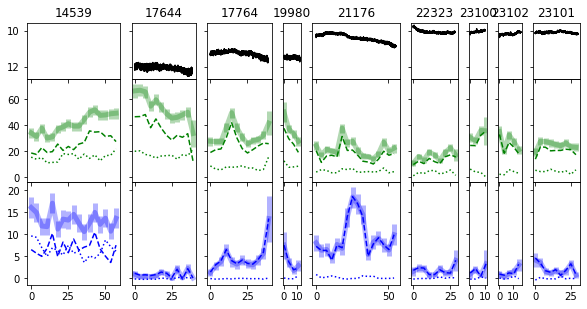

In [321]:
fig = plt.figure(figsize=(8, 13))

nlc = len(lccurves)

width = np.array([lc[0]['t'][-1] for lc in lccurves])
width = width / width.sum() * 0.8  # last factor is scale factor to make space for label left of plot
dy = [0.11, 0.11, 0.06]
ypos = [0.1, 0.21, 0.32]
axes = []
for y in range(3):
    for x in range(len(lccurves)):
        kwargs = {}
        if y != 0:
            kwargs['sharex'] = axes[x]
        if x != 0:
            kwargs['sharey'] = axes[y * nlc]
        axes.append(fig.add_axes((.1 + np.sum(width[0:x]) + x * 0.02, ypos[y], width[x], dy[y]), **kwargs))

for j in range(3):
    for i in range(1, nlc):
        plt.setp(axes[j * nlc + i].get_yticklabels(), visible=False)
        
for j in [1, 2]:
    for i in range(nlc):
        plt.setp(axes[j * nlc + i].get_xticklabels(), visible=False)
    
for i, obsid in enumerate(data['ObsID'][:-2]):
    axes[0 * nlc + i].errorbar(lccurves[i][0]['t']/1e3, lccurves[i][0]['NET_RATE_all'] * 1e3, lccurves[i][0]['ERR_RATE_all'] * 1e3, 
                             label='0.3-9.0 keV', color='b', lw=5, alpha=0.3)
    axes[0 * nlc + i].plot(lccurves[i][0]['t']/1e3, lccurves[i][0]['NET_RATE_soft'] * 1e3, 
                         color='b', ls=':', label='0.3-1.0 keV')
    axes[0 * nlc + i].plot(lccurves[i][0]['t']/1e3, lccurves[i][0]['NET_RATE_hard'] * 1e3, 
                         color='b', ls='--', label='1.0-9.0 keV')
    axes[1 * nlc + i].errorbar(lccurves[i][1]['t']/1e3, lccurves[i][1]['NET_RATE_all'] * 1e3, lccurves[i][1]['ERR_RATE_all'] * 1e3,
                             label='0.3-9.0 keV', color='g', lw=5, alpha=0.3)
    axes[1 * nlc + i].plot(lccurves[i][1]['t']/1e3, lccurves[i][1]['NET_RATE_soft'] * 1e3, 
                         color='g', ls=':', label='0.3-1.0 keV')
    axes[1 * nlc + i].plot(lccurves[i][1]['t']/1e3, lccurves[i][1]['NET_RATE_hard'] * 1e3, 
                     color='g', ls='--', label='1.0-9.0 keV')
    axes[2 * nlc + i].set_title(obsid)
    # ACA data
    if i > 0:
        axes[2 * nlc + i].plot((lcaca[i - 1]['time'] - lcaca[i - 1]['time'][0]) / 1e3, lcaca[i - 1]['mag'], color='k')
   
axes[2 * nlc].invert_yaxis()


In [322]:
for obsid in data['ObsID'][:-2]:
    lcall = Table.read('data/Chandra/{0}_{1}_lc.fits'.format(obsid, 'srca'), hdu=1)
    print(obsid, np.sum(lcall['COUNTS']))

14539 745
17644 46
17764 171
19980 36
21176 484
22323 50
23100 15
23102 26
23101 67


In [49]:
for row in data:
    ui.load_data(row['filestem'] + '_B', 'data/Chandra/' + row['filesrcB'])
    ui.load_bkg(row['filestem'] + '_B', 'data/Chandra/' + row['filebkgB'])                  
    ui.load_data(row['filestem'] + '_A', 'data/Chandra/' + row['filesrcA'])
    ui.load_bkg(row['filestem'] + '_A', 'data/Chandra/' + row['filebkgA'])                     

read ARF file data/Chandra/14539_B.corr.arf
read RMF file data/Chandra/14539_B.rmf
read ARF (background) file data/Chandra/14539_B_bkg.arf
read RMF (background) file data/Chandra/14539_B_bkg.rmf
read background file data/Chandra/14539_B_bkg.pi
read ARF (background) file data/Chandra/14539_B_bkg.arf
read RMF (background) file data/Chandra/14539_B_bkg.rmf
read ARF file data/Chandra/14539_A.corr.arf
read RMF file data/Chandra/14539_A.rmf
read ARF (background) file data/Chandra/14539_A_bkg.arf
read RMF (background) file data/Chandra/14539_A_bkg.rmf
read background file data/Chandra/14539_A_bkg.pi
read ARF (background) file data/Chandra/14539_A_bkg.arf
read RMF (background) file data/Chandra/14539_A_bkg.rmf
read ARF file data/Chandra/17644_B.corr.arf
read RMF file data/Chandra/17644_B.rmf
read ARF (background) file data/Chandra/17644_B_bkg.arf
read RMF (background) file data/Chandra/17644_B_bkg.rmf
read background file data/Chandra/17644_B_bkg.pi
read ARF (background) file data/Chandra/1764

In [50]:
ui.notice(None, None)

In [51]:
ui.get_filter('22323_A')

'0.974549999228:10.409800291061'

In [52]:
for o in ui.list_data_ids():
    ui.group_width(o, 1)

In [53]:
ui.set_analysis('energy')
ui.ignore(None, 0.3)
ui.ignore(9., None)

In [54]:
ui.get_filter('22323_A')

'0.313900008798:8.986299991608'

### AAVSO data

In [55]:
aavso = Table.read('data/aavso.txt', format='ascii.csv', fill_values = ('N/A', 0))
# Sometimes the Magnitude column contains the "<" sing for upper limits.
aavso['Mag'] = np.zeros(len(aavso))
for i in range(len(aavso)):
    try:
        aavso['Mag'][i] = float(aavso['Magnitude'][i])
    except ValueError:
        aavso['Mag'][i] = np.ma.masked

/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/astropy/table/column.py:984: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/astropy/table/column.py:984: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/astropy/table/column.py:984: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/astropy/table/column.py:984: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/astropy/table/column.py:984: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/astropy/table/co

/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/astropy/table/column.py:984: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value


In [231]:
bands = dict([('Vis.', {'color': (1., 0.5, 1.), 'marker': '.'}),
                     ('B', {'color': 'b', 'marker': 'p'}),
                     ('V', {'color': 'g', 'marker': 'o'}),
                     ('R', {'color': 'r', 'marker': '*'}),
                     ('ACA', {'color': 'k', 'marker': 'D', 'markersize': 7})
                    ])
def plotaavso(ax):
    for band in bands:
        ind = (aavso['Band'] == band)
        ax.plot(aavso['JD'][ind]-2400000.5, aavso['Mag'][ind], linestyle='None', **bands[band], label=band)

In [324]:
obstimes = np.array([[Time(lc[0]['TIME_MIN'][0], format='cxcsec').mjd, 
             Time(lc[0]['TIME_MAX'][-1], format='cxcsec').mjd] for lc in lccurves])

In [329]:
# Add Chandra ACA magnitudes
for l in lcaca:
    aavso.add_row({'JD': Time(l['time'].mean(), format='cxcsec').jd, 'Mag': l['mag'].mean(), 'Band': 'ACA'})

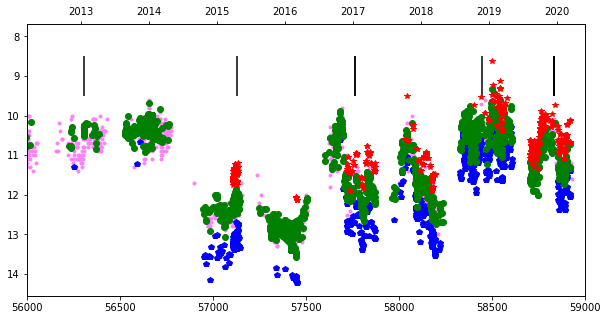

In [246]:
def years(tmjd):
    return Time(tmjd, format='mjd').decimalyear

def update_axyears(ax):
   y1, y2 = ax.get_xlim()
   axy.set_xlim(years(y1), years(y2))
   ax.figure.canvas.draw()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
axy = ax.twiny()
# automatically update ylim of ax2 when ylim of ax1 changes.
ax.callbacks.connect("xlim_changed", update_axyears)

plotaavso(ax)
ax.set_xlim([56000, 59000])
ax.invert_yaxis()

ax.eventplot(obstimes[:, 0], colors=['k'], lineoffsets=[9],
                    linelengths=[1])

In [247]:
from matplotlib.ticker import MaxNLocator, MultipleLocator
    
from matplotlib.transforms import Bbox, TransformedBbox, \
    blended_transform_factory, Affine2D

from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,\
    BboxConnectorPatch

# code for zoom effects taken and modified from http://matplotlib.org/users/annotations_guide.html
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1)*0.2

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p


def zoom_effect(ax1, ax2, xtrans=Affine2D(), **kwargs):
    """
    ax1 : the main axes
    ax2 : the zoomed axes

    connect ax1 & ax2. The x-range of (xmin, xmax) in both axes will
    be marked.  The keywords parameters will be used ti create
    patches. The xmin & xmax will be taken from the
    ax1.viewLim.
    """

    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(xtrans + ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)

    prop_patches = kwargs.copy()
    prop_patches["ec"] = "none"
    prop_patches["alpha"] = 0.2

    # The inversion messes up the coner points.
    # This is tweaked for inverted axes.
    # I'm sure ther is some clever way to use the right transforms for the y axis 
    # to take care of that automatically, but for 
    # a one-off script it's much simpler to just adjust the corners by hand.
    if ax1.yaxis_inverted():
        loc2a = 2
        loc2b = 1
    else:
        loc2a = 3
        loc2b = 4
    
    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=2, loc2a=loc2a, loc1b=1, loc2b=loc2b,
                     prop_lines=kwargs, prop_patches=prop_patches)

    #ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

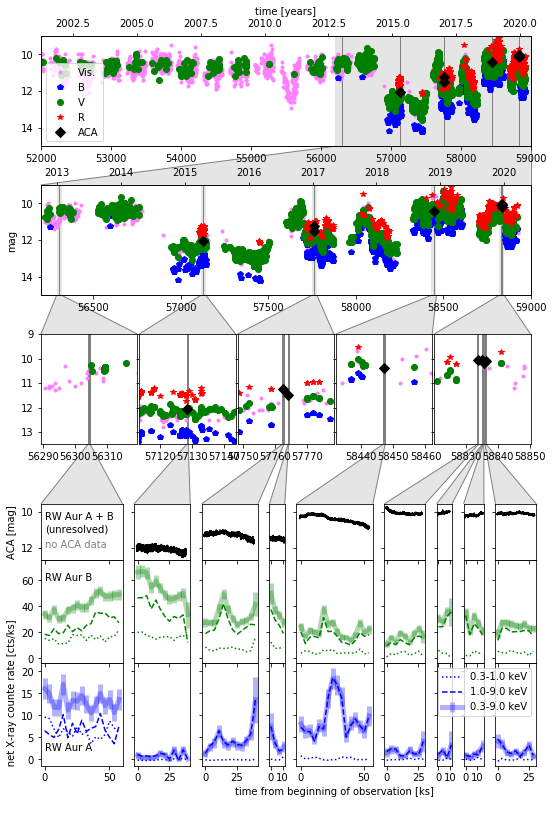

In [336]:
obsids = data['ObsID'][:-2]
n_obsids = len(obsids)
year = np.array(list(set([int(y) for y in data['year']])))
year.sort()
n_years = len(year)

fig = plt.figure(figsize=(8, 13))
ax00 = fig.add_subplot(511)
ax11 = fig.add_subplot(512)

n_years = len(set(data['year']))
axrow2 = [fig.add_subplot(5, n_years, 2 * n_years + 1)]
for i in range(2, n_years+1):
    axrow2.append(fig.add_subplot(5, n_years, 2 * n_years + i, sharey=axrow2[0]))

# Set up second x-axis for top plot that is labeled in years
ax00years = ax00.twiny()
ax11years = ax11.twiny()

def years(tmjd):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ErfaWarning)
        t = Time(tmjd, format='mjd').decimalyear
    return t

def update_ax11years(ax11):
   y1, y2 = ax11.get_xlim()
   ax11years.set_xlim(years(y1), years(y2))
   ax11.figure.canvas.draw()

def update_ax00years(ax00):
   y1, y2 = ax00.get_xlim()
   ax00years.set_xlim(years(y1), years(y2))
   ax00.figure.canvas.draw()

# automatically update ylim of ax2 when ylim of ax1 changes.
ax00.callbacks.connect("xlim_changed", update_ax00years)
ax11.callbacks.connect("xlim_changed", update_ax11years)

for ax in fig.axes:
    plotaavso(ax)
    
for ax in fig.axes:
    for i in range(obstimes.shape[0]):
        ax.bar(obstimes[i, 0], height=10, width=obstimes[i, 1]-obstimes[i, 0], bottom=8, align='edge', 
               color='0.5', edgecolor='0.5')

ax00.invert_yaxis()
ax11.invert_yaxis()
ax00.set_xlim([52000, 59000])
ax11.set_xlim([56200, 59000])

dtime = 15.
for i, y in enumerate(year):
    meanmjd = np.mean(obstimes[data['year'][:-2] == str(y)])
    axrow2[i].set_xlim(meanmjd - dtime, meanmjd + dtime)
    axrow2[i].get_xaxis().get_major_formatter().set_useOffset(False)
    axrow2[i].xaxis.set_major_locator( MaxNLocator(nbins=3, steps=[5, 10]) )
    if i > 0:
        plt.setp(axrow2[i].get_yticklabels(), visible=False)
    #axrow2[i].set_title(y)
        
axrow2[0].invert_yaxis()

ax00.legend(numpoints=1, loc='lower left')
ax11.set_ylabel('mag')
ax21.set_ylabel('mag')
ax22.set_xlabel('time [MJD]')
ax00years.set_xlabel('time [years]')

axrow2[0].set_ylim([13.5, 9])
ax11.set_ylim([15, 9])
ax00.set_ylim([15, 9])

width = np.array([lc[0]['t'][-1] for lc in lccurves])
width = width / width.sum() * 0.7  # last factor is scale factor to make space for label left of plot
dy = [0.11, 0.11, 0.06]
ypos = [0.1, 0.21, 0.32]
axes = []


for y in range(3):
    for x in range(n_obsids):
        kwargs = {}
        if y != 0:
            kwargs['sharex'] = axes[x]
        if x != 0:
            kwargs['sharey'] = axes[y * n_obsids]
        axes.append(fig.add_axes((.1 + np.sum(width[0:x]) + x * 0.02, ypos[y], width[x], dy[y]), **kwargs))
        
for j in range(3):
    for i in range(1, n_obsids):
        plt.setp(axes[j * n_obsids + i].get_yticklabels(), visible=False)
        
for j in [1, 2]:
    for i in range(n_obsids):
        plt.setp(axes[j * n_obsids + i].get_xticklabels(), visible=False)

for i, obsid in enumerate(obsids):
    axes[0 * n_obsids + i].errorbar(lccurves[i][0]['t']/1e3, lccurves[i][0]['NET_RATE_all'] * 1e3, lccurves[i][0]['ERR_RATE_all'] * 1e3, 
                             label='0.3-9.0 keV', color='b', lw=5, alpha=0.3)
    axes[0 * n_obsids + i].plot(lccurves[i][0]['t']/1e3, lccurves[i][0]['NET_RATE_soft'] * 1e3, 
                         color='b', ls=':', label='0.3-1.0 keV')
    axes[0 * n_obsids + i].plot(lccurves[i][0]['t']/1e3, lccurves[i][0]['NET_RATE_hard'] * 1e3, 
                         color='b', ls='--', label='1.0-9.0 keV')
    axes[1 * n_obsids + i].errorbar(lccurves[i][1]['t']/1e3, lccurves[i][1]['NET_RATE_all'] * 1e3, lccurves[i][1]['ERR_RATE_all'] * 1e3,
                             label='0.3-9.0 keV', color='g', lw=5, alpha=0.3)
    axes[1 * n_obsids + i].plot(lccurves[i][1]['t']/1e3, lccurves[i][1]['NET_RATE_soft'] * 1e3, 
                         color='g', ls=':', label='0.3-1.0 keV')
    axes[1 * n_obsids + i].plot(lccurves[i][1]['t']/1e3, lccurves[i][1]['NET_RATE_hard'] * 1e3, 
                     color='g', ls='--', label='1.0-9.0 keV')
    #axes[2 * 4 + i].set_title(obsid)
    if i > 0:
        axes[2 * n_obsids + i].plot((lcaca[i-1]['time'] - lccurves[i][0]['TIME'][0]) / 1e3, # Subtract 0 point of X-ray lc
                                    lcaca[i - 1]['mag'], color='k')
    
#axes[n_obsids * 2].yaxis.set_major_locator( MaxNLocator(nbins=4) )
axes[8].legend()
axes[n_obsids * 2].invert_yaxis()
# axes[n_obsids + 8].legend()
axes[0].set_ylabel('              net X-ray counte rate [cts/ks]')
axes[4].set_xlabel('time from beginning of observation [ks]')
axes[n_obsids * 2].set_ylabel('ACA [mag]')
axes[n_obsids].text(0., 60., 'RW Aur B')
axes[0].text(0, 2., 'RW Aur A')
axes[n_obsids * 2].text(0, 11.1, 'RW Aur A + B\n(unresolved)')
axes[n_obsids * 2].text(0, 12, 'no ACA data', color='0.5')
#axes[n_obsids * 2].text(35., 11, '2013-Jan')
#axes[n_obsids * 2 + 1].text(15, 11., '2015-Apr')
#axes[n_obsids * 2 + 2].text(15, 11.5, '2017-Jan-09')
#axes[n_obsids * 2 + 3].text(-2, 11.5, '2017\nJan-11')

zoom_effect(ax11, ax00, color='0.5')
for ax in axrow2:
    zoom_effect(ax, ax11, color='0.5')
for i in range(n_obsids):
    zoom_effect(axes[2 * n_obsids + i], axrow2[np.nonzero(year == int(data['year'][i]))[0][0]], 
                xtrans=Affine2D.from_values(1./(24*3600/1000), 0, 0, 1, obstimes[i, 0], 0), color='0.5')
               
                   
fig.subplots_adjust(wspace=0.02, hspace=.35, left=0.1, right=0.95)

#fig.savefig(os.path.join(figout, 'lc.pdf'), bbox_inches='tight')
#fig.savefig(os.path.join(figout, 'lc.png'), bbox_inches='tight', dpi=600)

## The spectrum of RW Aur B
This needs tobe modeled, because we will use it as a component in the RW Aur A model to account for the contamination of the RW Aur A data by signal coming from RW Aur B.

Text(0.5, 1, 'RW Aur B')

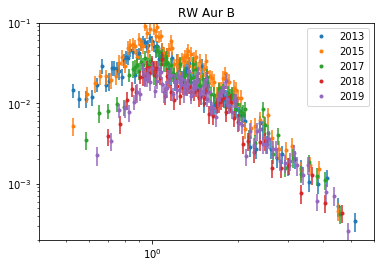

In [157]:
for i in ui.list_data_ids():
    if i[-2:] == '_B':
        ui.group_counts(i, 15)
    
for i in plotorder:
    ui.plot_data(data['filestem'][i] + '_B', overplot=True, color=data['color'][i])
    
ax = plt.gca()
ax.loglog()
ax.set_xlim(.4, 6)
ax.set_ylim(2e-4, 0.1)
ax.legend(ax.get_lines(), data['year'][plotorder])
ax.set_title('RW Aur B')

In [58]:
years = list(set(data['year']))
years.sort()

b_models = {y: ui.xsphabs(name='Ba_'+y) * (ui.xsvapec(name='Bv1_'+y) + ui.xsvapec(name='Bv2_'+y)) for y in years}

for row in data:
    ui.set_source(row['filestem'] + '_B', b_models[row['year']])

In [59]:
for bo in b_models.values():
    for elem in ['C', 'N', 'O','Ne', 'Fe', 'Si', 'Mg']:
        setattr(bo.rhs.rhs, elem, getattr(bo.rhs.lhs, elem))
    bo.rhs.lhs.kT = 0.5
    bo.rhs.rhs.kT = 2.0

In [60]:
ui.show_model()

Model: 14539_B
apply_rmf(apply_arf((54482.855450192 * (xsphabs.Ba_2013 * (xsvapec.Bv1_2013 + xsvapec.Bv2_2013)))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Ba_2013.nH   thawed            1            0       100000 10^22 atoms / cm^2
   Bv1_2013.kT  thawed          0.5       0.0808       68.447        keV
   Bv1_2013.He  frozen            1            0         1000           
   Bv1_2013.C   frozen            1            0         1000           
   Bv1_2013.N   frozen            1            0         1000           
   Bv1_2013.O   frozen            1            0         1000           
   Bv1_2013.Ne  frozen            1            0         1000           
   Bv1_2013.Mg  frozen            1            0         1000           
   Bv1_2013.Al  frozen            1            0         1000           
   Bv1_2013.Si  frozen            1            0         1000           
 

In [61]:
to_fit_B = [row['filestem']+'_B' for row in data if row['filestem']==row['ObsID']]

In [62]:
# Leaving these independent can actually lead to the worse chi^2, so no reason to suspect that nH is changeing
# Fix to reduce number of parameters in fit

for y in years[1:]:
    b_models[y].lhs.nH = b_models[years[0]].lhs.nH

ui.fit(*to_fit_B)

Datasets              = '14539_B', '17644_B', '17764_B', '19980_B', '21176_B', '22323_B', '23100_B', '23101_B', '23102_B'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 4.75752e+10
Final fit statistic   = 460.184 at function evaluation 714
Data points           = 438
Degrees of freedom    = 417
Probability [Q-value] = 0.070845
Reduced statistic     = 1.10356
Change in statistic   = 4.75752e+10
   Ba_2013.nH     0.810632     +/- 0.0494922   
   Bv1_2013.kT    0.222772     +/- 0.0108338   
   Bv1_2013.norm   0.00170123   +/- 0.000445116 
   Bv2_2013.kT    1.80353      +/- 0.123337    
   Bv2_2013.norm   0.000284781  +/- 1.51451e-05 
   Bv1_2015.kT    0.190265     +/- 0.0119443   
   Bv1_2015.norm   0.00419749   +/- 0.00150865  
   Bv2_2015.kT    1.46879      +/- 0.0680867   
   Bv2_2015.norm   0.000448666  +/- 2.18935e-05 
   Bv1_2017.kT    0.178235     +/- 0.0105422   
   Bv1_2017.norm   0.00334441   +/- 0.00131181  
   Bv2_2017.kT    1.56863 

In [63]:
for row in data:
    ui.subtract(row['filestem']+'_B')

In [64]:
# It seems that joining the temperature of both components should work well
for y in years[1:]:
    b_models[y].rhs.lhs.kT = b_models[years[0]].rhs.lhs.kT
    b_models[y].rhs.rhs.kT = b_models[years[0]].rhs.rhs.kT
    
ui.fit(*to_fit_B)

Datasets              = '14539_B', '17644_B', '17764_B', '19980_B', '21176_B', '22323_B', '23100_B', '23101_B', '23102_B'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 1135.98
Final fit statistic   = 434.319 at function evaluation 157
Data points           = 438
Degrees of freedom    = 425
Probability [Q-value] = 0.366865
Reduced statistic     = 1.02193
Change in statistic   = 701.664
   Ba_2013.nH     1.04807      +/- 0.0433736   
   Bv1_2013.kT    0.174283     +/- 0.00338537  
   Bv1_2013.norm   0.00893534   +/- 0.00196771  
   Bv2_2013.kT    1.56009      +/- 0.0383129   
   Bv2_2013.norm   0.000308828  +/- 1.52127e-05 
   Bv1_2015.norm   0.0143061    +/- 0.00315025  
   Bv2_2015.norm   0.000478615  +/- 2.41797e-05 
   Bv1_2017.norm   0.0083979    +/- 0.00194041  
   Bv2_2017.norm   0.000380118  +/- 1.8987e-05  
   Bv1_2018.norm   0.00775025   +/- 0.00178226  
   Bv2_2018.norm   0.00025722   +/- 1.6111e-05  
   Bv1_2019.norm   0.00809255  

The spectra are so remarkebly similar, it's almost uncanning, given the change in flux that I see in the lightcurve. It seems that all the variability I see within one observation washes out when I add the data from the entire observation together. It might actually we worth investigating, if there are any changes at all! The norms are significantly different, though.

I tried freeing abundances, but this is so close to defaults, there really is no reason to set them to anything else than 1.

In [151]:
mplcolors

{'2013': '#1f77b4',
 '2015': '#ff7f0e',
 '2017': '#2ca02c',
 '2018': '#d62728',
 '2019': '#9467bd'}

Text(0.5, 1, 'RW Aur B')

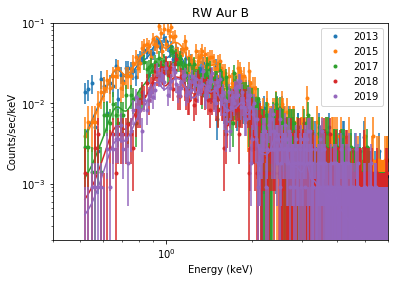

In [154]:
# Use the following line to change the size of the figure
# fig = plt.figure(figsize=(15,10))

for i,j  in enumerate(plotorder):
    ui.plot_fit(data['filestem'][j] + '_B', overplot=not (i==0), color=data['color'][j])
    
ax = plt.gca()
ax.loglog()
ax.set_xlim(.4, 6)
ax.set_ylim(2e-4, 0.1)
ax.legend(ax.get_lines()[::2], data['year'][plotorder])
ax.set_title('RW Aur B')

Text(0.5, 1, 'Bkg for RW Aur B')

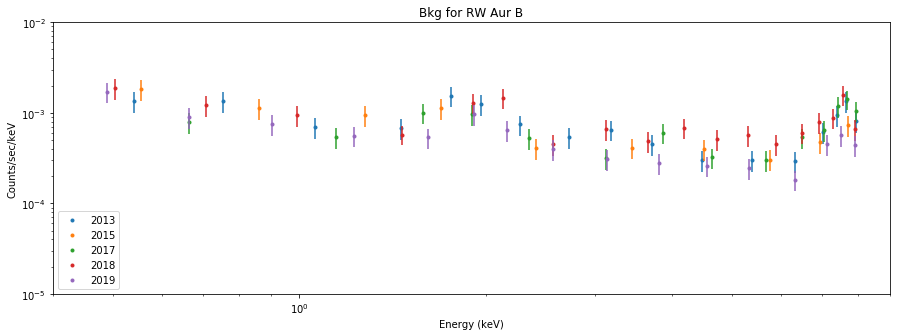

In [158]:
# Use the following line to change the size of the figure
fig = plt.figure(figsize=(15,5))

for i,j  in enumerate(plotorder):
    ui.plot_bkg(data['filestem'][j] + '_B', overplot=not (i==0), color=data['color'][j])
    
ax = plt.gca()
ax.loglog()
ax.set_xlim(.4, 9)
ax.set_ylim(1e-5, 0.01)
ax.legend(ax.get_lines(), data['year'][plotorder])
ax.set_title('Bkg for RW Aur B')

## The PSF of RW Aur B

Te PSF might be different from observation to observation for several reasons. In particular, the ACA monitoring may lead to a degradation of the PSF. A larger PSF means that more photons from RW Aur B will contaminate the extraction region of RW Aur A. Thus, I first try to get a quantitative measure of the PSF.

In [67]:
radprofs = [Table.read('data/Chandra/{0}_rprofile.fits'.format(o), hdu=1) for o in data['filestem'][:-2]]

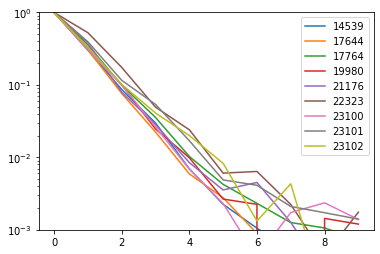

In [68]:
for r in radprofs:
    plt.semilogy(r['SUR_BRI'] / r['SUR_BRI'][0], label=r.meta['OBS_ID'])
plt.ylim(.001, 1)
plt.legend()


The observations taken in 2019 (22323, 23100, 23101, 23102) are significantly above the olders ones in annulus 3-6, which is the area overlapping with source A and the area in which we calculate the background for A. It's not much in absolute terms, but it cearly means that the scaling factor between B spectrum as background for A must be different in 2019 and the previous years.

## The spectrum of RW Aur A

Text(0.5, 1, 'RW Aur A')

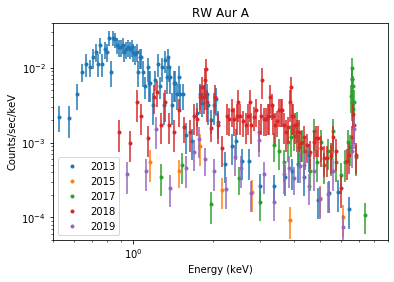

In [159]:
#fig = plt.figure(figsize=(12, 10))
for i in ui.list_data_ids():
    if i[-2:] == '_A':
        ui.group_counts(i, 5)
    
for i in plotorder:
    ui.plot_data(data['filestem'][i] + '_A', overplot=not(i==plotorder[0]), color=data['color'][i])
    
ax = plt.gca()
ax.loglog()
ax.set_xlim(.5, 9)
ax.set_ylim(5e-5, 0.04)
ax.legend(ax.get_lines(), data['year'][plotorder])
ax.set_title('RW Aur A')

In [70]:
ui.get_filter('22323_A')

'0.536549975863:10.833200216293'

In [71]:
to_fit_A = [row['filestem']+'_A' for row in data if row['filestem']==row['ObsID']]

In [72]:
scaleB_early = ui.scale1d(name='scaleB_early')
scaleB_2019 = ui.scale1d(name='scaleB_2019')

scaleB = {'2013': scaleB_early, '2015': scaleB_early, '2017': scaleB_early, '2018': scaleB_early, 
          '2019': scaleB_2019}

# Freeze everything in B models except the scale
for row in data:
    b_mod = b_models[row['year']]
    ui.set_bkg_source(row['filestem'] + '_A', scaleB[row['year']] * b_mod)
    
    for model in [b_mod.lhs, b_mod.rhs.lhs, b_mod.rhs.rhs]:
        for par in model.pars:
            par.frozen=True

In [73]:
# Some of the 2019 datasets have too few counts to make a fit at all. So, use merged dataset here.
# If the count numbers are so small, the error is dominated by counting statistics and not by systematics
# of coadding spectra.

# Can revisit this after I find where all the counts went.
ui.fit_bkg('14539_A', '17644_A', '2017_A', '21176_A', '2019_A')

Datasets              = '14539_A', '17644_A', '2017_A', '21176_A', '2019_A'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 72641.3
Final fit statistic   = 105.516 at function evaluation 6
Data points           = 145
Degrees of freedom    = 143
Probability [Q-value] = 0.991939
Reduced statistic     = 0.737872
Change in statistic   = 72535.8
   scaleB_early.c0   0.0535013    +/- 0.00375655  
   scaleB_2019.c0   0.0863664    +/- 0.00960275  


Text(0.5, 1, 'Bkg for RW Aur A')

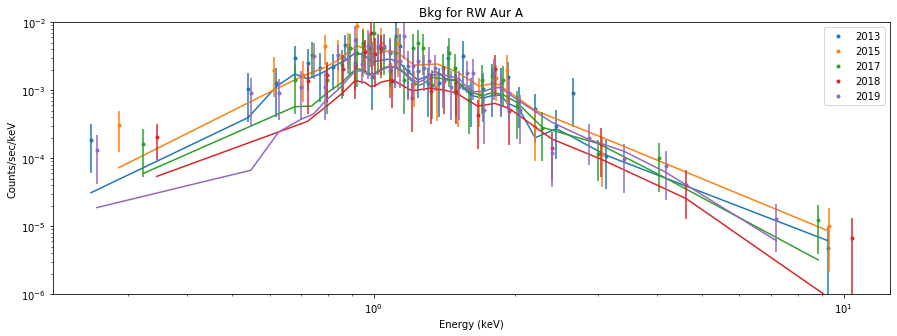

In [74]:
# Use the following line to change the size of the figure
fig = plt.figure(figsize=(15,5))

for i,j  in enumerate(plotorder):
    ui.plot_bkg_fit(data['filestem'][j] + '_A', overplot=not (i==0), color=data['color'][j])
    
ax = plt.gca()
ax.loglog()
#ax.set_xlim(.4, 9)
ax.set_ylim(1e-6, 0.01)
ax.legend(ax.get_lines()[::2], data['year'][plotorder])
ax.set_title('Bkg for RW Aur A')

Here, I see that the background is described quite well in the early observations, but, even with the higher scaling factor for 2019, the 2019 background is significantly underpredicted on the soft end. That will cause an apparent soft component in the RW Aur A model, that in trouth is just the background. What's surprising is that the shape of the observed background spectrum has not changed at all. ACIS contamination should reduce the number of soft counts detected (and it does in the RW Aur B spectrum), so why is the number of soft counts not going down here? The rate is far too high to be explained with particle background. Is the soft PSF so much wider than the hard PSF?

While an answer would be good, really what I need is a model that describes the background well enough so I can carry on with fitting. On the other hand, I'm reluctant to introduce a new component that's fit to just a few bins.

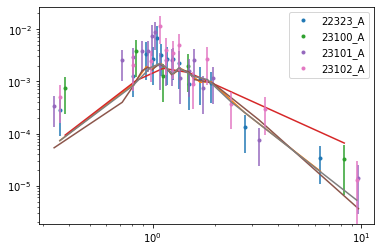

In [75]:
ids = ['22323_A', '23100_A', '23101_A', '23102_A'] #, '2019_A']
for o in ids:
    ui.plot_bkg_fit(o, overplot=True)
ax = plt.gca()
ax.loglog()
#ax.set_xlim(.4, 9)
#ax.set_ylim(1e-5, 0.01)
ax.legend(ax.get_lines()[::2], ids)

In [76]:
for row in data:
    ui.unsubtract(row['filestem']+'_B')

for o in ui.list_data_ids():
    ui.group_width(o, 1)
    ui.set_analysis(o, "bin", "counts", 0)
    pl = ui.get_data_plot(o)
    pl1 = ui.get_bkg_plot(o)
    print('{}: {} - {}'.format(o, pl.y.sum(), pl1.y.sum()))
    
ui.set_analysis("energy")

14539_A: 747.0 - 186.0
14539_B: 2246.0 - 1544.0
17644_A: 48.0 - 123.0
17644_B: 1912.0 - 1043.0
17764_A: 171.0 - 142.0
17764_B: 1253.0 - 1188.0
19980_A: 36.0 - 34.0
19980_B: 353.0 - 330.0
2017_A: 207.0 - 176.0
2017_B: 1605.0 - 1369.0
2019_A: 160.0 - 252.0
2019_B: 1785.0 - 898.0
21176_A: 484.0 - 113.0
21176_B: 1084.0 - 1455.0
22323_A: 51.0 - 74.0
22323_B: 427.0 - 512.0
23100_A: 16.0 - 24.0
23100_B: 291.0 - 184.0
23101_A: 67.0 - 94.0
23101_B: 682.0 - 534.0
23102_A: 26.0 - 60.0
23102_B: 384.0 - 167.0


In [77]:
scaleB_early.c0.frozen = True
scaleB_2019.c0.frozen = True

### Line-diagnostics
Of course, we do not really resolve individual lines in ACIS spectra, but below it looks like I should. So, at the very least, I can use CHIANTI to see H/He-like line ratios.

In [78]:
logtemp = np.arange(5.8, 8.5, .1)
temp = 10**logtemp

def intensityHHe(temp, Hion, Heion):
    Helike = ch.ion(Heion, temperature=temp, eDensity=1.e+9, em=1.e+27)
    Helike.intensity()
    Hlike = ch.ion(Hion, temperature=temp, eDensity=1.e+9, em=1.e+27)
    Hlike.intensity()

    e_r = Helike.Intensity['intensity'][:, (Helike.Intensity['lvl1'] == 1) & (Helike.Intensity['pretty2'] == '1s.2p 1P1.0')].flatten()
    e_i1 = Helike.Intensity['intensity'][:, (Helike.Intensity['lvl1'] == 1) & (Helike.Intensity['pretty2'] == '1s.2p 3P2.0')].flatten()
    e_i2 = Helike.Intensity['intensity'][:, (Helike.Intensity['lvl1'] == 1) & (Helike.Intensity['pretty2'] == '1s.2p 3P1.0')].flatten()
    e_f = Helike.Intensity['intensity'][:, (Helike.Intensity['lvl1'] == 1) & (Helike.Intensity['pretty2'] == '1s.2s 3S1.0')].flatten()

    e_lya1 = Hlike.Intensity['intensity'][:, (Hlike.Intensity['lvl1'] == 1) & (Hlike.Intensity['pretty2'] == '2s 2S0.5')].flatten()
    e_lya2 = Hlike.Intensity['intensity'][:, (Hlike.Intensity['lvl1'] == 1) & (Hlike.Intensity['pretty2'] == '2p 2P0.5')].flatten()
    e_lya3 = Hlike.Intensity['intensity'][:, (Hlike.Intensity['lvl1'] == 1) & (Hlike.Intensity['pretty2'] == '2p 2P1.5')].flatten()
    
    return e_lya1 + e_lya2 + e_lya3, e_r + e_i1 + e_i2 + e_f

(0.1, 10)

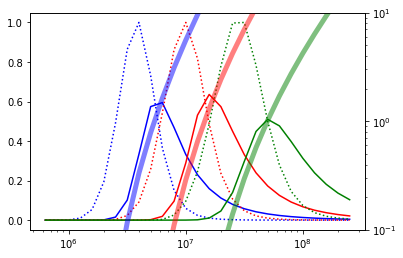

In [79]:
fig, ax = plt.subplots()
axt = ax.twinx()
    
for Heion, Hion, color in ([('ne_9', 'ne_10', 'b'), ('si_13', 'si_14', 'r'), ('ca_19', 'ca_20', 'g')]):
    e_H, e_He = intensityHHe(temp, Hion, Heion)

    ax.semilogx(temp, e_H / np.max(e_He), color=color)
    ax.semilogx(temp, e_He / np.max(e_He), color=color, ls=':')

    axt.semilogy(temp, e_H / e_He, color=color, lw=5, alpha=.5)

#ax.loglog()
axt.set_ylim(0.1, 10)

In [80]:
a_models = {y: ui.xsphabs(name='Aa_'+y) * (ui.xsvapec(name='Av1_'+y) + ui.xsvapec(name='Av2_'+y)) for y in years}

for row in data:
    a_mod = a_models[row['year']]
    ui.set_source(row['filestem'] + '_A', a_mod)
    for elem in ['C', 'N', 'O','Ne', 'Mg', 'Al', 'Si', 'S', 'Ar', 'Ca', 'Fe', 'Ni']:
        setattr(a_mod.rhs.rhs, elem, getattr(a_mod.rhs.lhs, elem))
    a_mod.lhs.nH.frozen = False

In [82]:
for i in ui.list_data_ids():
    if i[-2:] == '_A':
        try:
            ui.ungroup(i)
        except sherpa.utils.err.DataErr:
            # It's already ungrouped
            pass
ui.set_stat('cash')

## 2013 - 2017
This is the data that is covered in previous publications already, so the fits here are mostly reproducing the models published there. I could just hardcode the numbers from the previous fits, but for now I actually run the fits again. Results look consistent, but I should probably check again.

In [141]:
# Set of kT=20 from Skinner & Guedel for 2013 data, fix kT as in Schneider et al for 2015 data
a_models['2013'].rhs.lhs.Ne.frozen = False
a_models['2013'].rhs.lhs.Fe.frozen = False
a_models['2013'].rhs.rhs.kT.frozen = True
a_models['2013'].rhs.rhs.kT = 20.

a_models['2015'].rhs.lhs.kT = a_models['2013'].rhs.lhs.kT
a_models['2015'].rhs.rhs.kT = a_models['2013'].rhs.rhs.kT

a_models['2017'].rhs.lhs.Fe.frozen = False
a_models['2017'].rhs.rhs.kT.frozen = True
a_models['2017'].rhs.rhs.kT = 20.

# Set models close to final to speed up convergence when running the notebook again
# This also redues the risk of running the fit into non-sensical minimums as I observed
# several times when I experimented with different binning, statistics etc.
a_models['2013'].lhs.nH = 0.3
a_models['2013'].rhs.lhs.kT = 0.4
a_models['2013'].rhs.lhs.norm = 1e-4
a_models['2013'].rhs.rhs.norm = 4e-5

a_models['2017'].lhs.nH = 45
a_models['2017'].rhs.lhs.kT = 1
a_models['2017'].rhs.lhs.Fe = 50

In [142]:
ui.ignore(None, .4)
ui.ignore(8., None)
        
ui.fit('14539_A')
#ui.fit('17644_A')
ui.fit('17764_A', '19980_A')

Dataset               = 14539_A
Method                = levmar
Statistic             = cash
Initial fit statistic = -1950.33
Final fit statistic   = -2013.26 at function evaluation 62
Data points           = 114
Degrees of freedom    = 108
Change in statistic   = 62.9308
   Aa_2013.nH     0.204915     +/- 0.127752    
   Av1_2013.kT    0.491339     +/- 0.0880505   
   Av1_2013.Ne    1.91858      +/- 0.741803    
   Av1_2013.Fe    0.470658     +/- 0.113938    
   Av1_2013.norm   6.44716e-05  +/- 3.0013e-05  
   Av2_2013.norm   4.07598e-05  +/- 4.91376e-06 
Datasets              = '17764_A', '19980_A'
Method                = levmar
Statistic             = cash
Initial fit statistic = 1.29137e+06
Final fit statistic   = -397.636 at function evaluation 118
Data points           = 64
Degrees of freedom    = 59
Change in statistic   = 1.29177e+06
   Aa_2017.nH     38.2879      +/- 5.87854     
   Av1_2017.kT    1.36546      +/- 0.278814    
   Av1_2017.Fe    16.1296      +/- 11.7191     
   

In [143]:
# Freeze parameters that we want to take from the 2013 fit at the values
# fitted above to the 2013 data
a_models['2015'].rhs.lhs.kT.frozen = True
a_models['2015'].rhs.rhs.kT.frozen = True
a_models['2015'].rhs.lhs.kT = a_models['2013'].rhs.lhs.kT
a_models['2015'].rhs.rhs.kT = a_models['2013'].rhs.rhs.kT

ui.fit('17644_A')

Dataset               = 17644_A
Method                = levmar
Statistic             = cash
Initial fit statistic = 5.7415e+06
Final fit statistic   = -197.41 at function evaluation 246
Data points           = 27
Degrees of freedom    = 24
Change in statistic   = 5.7417e+06
   Aa_2015.nH     4.96746      +/- 1.38438     
   Av1_2015.norm   0.000103468  +/- 1.51722e-05 
   Av2_2015.norm   2.4521e-05   +/- 1.57501e-05 


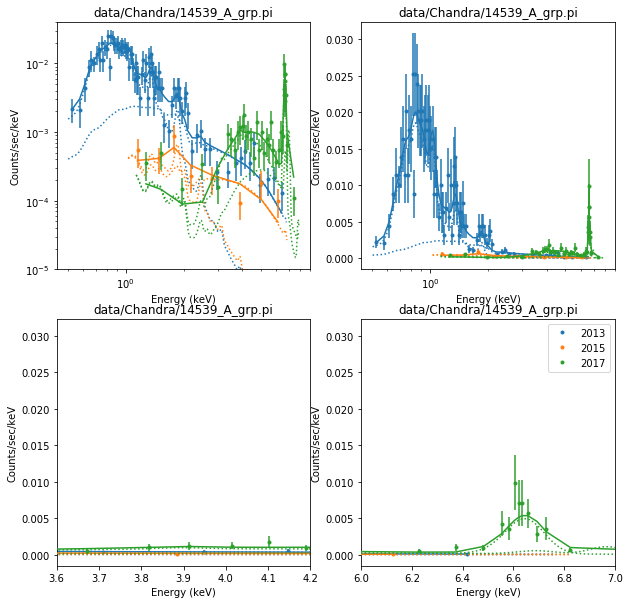

In [164]:
fig, axes= plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

for i in ui.list_data_ids():
    if i[-2:] == '_A':
        ui.group_counts(i, 5)

for ax in axes.flatten():
    plt.sca(ax)
    for i,j  in enumerate(plotorder[:3]):
        ui.plot_fit(data['filestem'][j] + '_A', overplot=not(i==0), 
                    color=data['color'][j], clearwindow=False)
        ui.plot_model_component(data['filestem'][j] + '_A', 
                                a_models[data['year'][j]].lhs * a_models[data['year'][j]].rhs.lhs,
                                overplot=True, color=data['color'][j], linestyle=':')
        ui.plot_model_component(data['filestem'][j] + '_A', 
                                a_models[data['year'][j]].lhs * a_models[data['year'][j]].rhs.rhs,
                                overplot=True, color=data['color'][j], linestyle=':')
    
axes[0, 0].loglog()
axes[0, 0].set_ylim(1e-5, 4e-2)
axes[0, 1].semilogx()
axes[1, 0].set_xlim(3.6, 4.2)
axes[1, 1].set_xlim(6., 7.)
axes[1, 1].legend(ax.get_lines()[::4], data['year'][plotorder[:3]])

### 2018

In [169]:
ui.ungroup('21176_A')

background 1 grouping flag is already False


DataErr: data set 21176_A grouping flag is already False

In [170]:
a_models['2018'].rhs.lhs.Si.frozen = False
a_models['2018'].rhs.lhs.Ca.frozen = False
a_models['2018'].rhs.lhs.Fe.frozen = False

abs1 = a_models['2018'].lhs
xsv1 = a_models['2018'].rhs.lhs
xsv2 = a_models['2018'].rhs.rhs

ui.set_source('21176_A', abs1 * (xsv1 + xsv2))

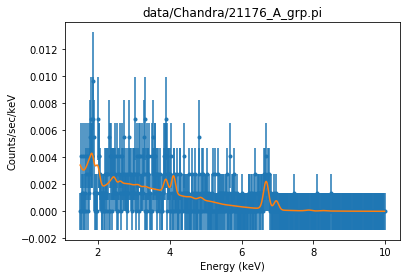

In [173]:
ui.plot_fit('21176_A')

In [198]:
xsv1.kT = 1.
xsv2.kT = 5
xsv1.kT.frozen = True
xsv2.kT.frozen = False
xsv1.norm = 1e-5
xsv2.norm = 1e-5
xsv2.norm.frozen=False

1.511099994183:9.979099750519
Dataset               = 21176_A
Method                = levmar
Statistic             = cash
Initial fit statistic = 839.669
Final fit statistic   = 839.669 at function evaluation 9
Data points           = 1162
Degrees of freedom    = 1155
Change in statistic   = 3.91755e-06
   Aa_2018.nH     6.45975      +/- 1.13295     
   Av1_2018.Si    2.00218      +/- 1.19081     
   Av1_2018.Ca    6.51742      +/- 3.95768     
   Av1_2018.Fe    3.07811      +/- 0.999608    
   Av1_2018.norm   0.000327765  +/- 0.000269259 
   Av2_2018.kT    4.58724      +/- 1.25006     
   Av2_2018.norm   0.00026317   +/- 6.44146e-05 


/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)


/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)


/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)


/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)


(6.0, 7.0)

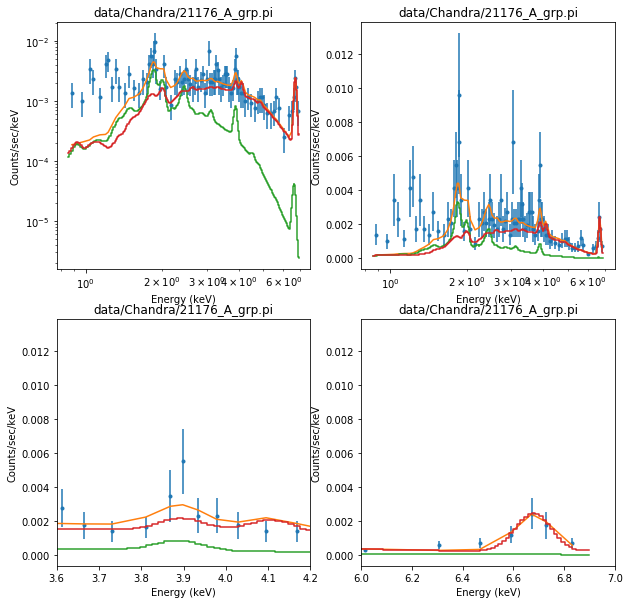

In [204]:
fig, axes= plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
#ui.set_stat('chi2gehrels')
ui.ungroup('21176_A')
#ui.unsubtract('21176_A')
ui.set_stat('cash')
ui.notice(1.5, 10.)
ui.ignore(None, 1.5)
ui.ignore(10., None)
print(ui.get_filter('21176_A'))
ui.fit('21176_A')
ui.group_counts('21176_A', 5)
ui.notice(.5, 10.)
ui.ignore(None, .5)
ui.ignore(10., None)
for ax in axes.flatten():
    plt.sca(ax)
    ui.plot_fit('21176_A', clearwindow=False)
    ui.plot_model_component('21176_A', abs1 * xsv1, overplot=True)
    ui.plot_model_component('21176_A', abs1 * xsv2, overplot=True)
    
    #ax.set_xlim(.5, 11.)
    
axes[0, 0].loglog()
axes[0, 1].semilogx()
axes[1, 0].set_xlim(3.6, 4.2)
axes[1, 1].set_xlim(6., 7.)

In [217]:
for par in [abs1.nH, xsv1.Si, xsv1.Ca, xsv1.Fe, xsv1.norm, xsv2.kT, xsv2.norm]:
    par.frozen = False

In [223]:
xsv1.kT.frozen = False

In [225]:
xsjeta = ui.xsvapec(name='xsjeta')
abs2 = ui.xsphabs('abs2')
ui.set_source('21176_A', xsjeta + abs1 * (xsv1 + xsv2))

In [226]:
abs2.nH = 0.1
abs2.nH.frozen = False

In [227]:
ui.set_method('simplex')

0.518299996853:9.979099750519
Dataset               = 21176_A
Method                = neldermead
Statistic             = cash
Initial fit statistic = 1084.4
Final fit statistic   = 1082.52 at function evaluation 2348
Data points           = 1298
Degrees of freedom    = 1288
Change in statistic   = 1.88835
   xsjeta.kT      68.4454     
   xsjeta.norm    5.28574e-05 
   Aa_2018.nH     14.5958     
   Av1_2018.kT    0.595029    
   Av1_2018.Si    7.9345      
   Av1_2018.Ca    5.31296     
   Av1_2018.Fe    3.82564     
   Av1_2018.norm   0.00319351  
   Av2_2018.kT    2.77935     
   Av2_2018.norm   0.000361426 


/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a sin

/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a sin

/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a sin

/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a sin

(6.0, 7.0)

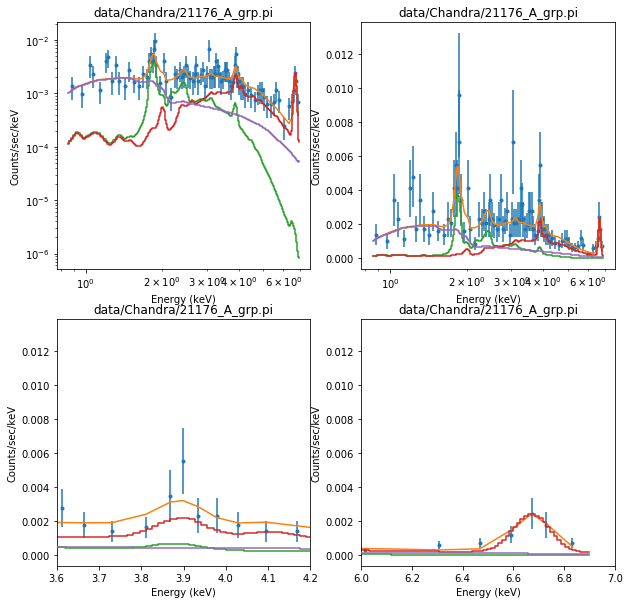

In [228]:
fig, axes= plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
#ui.set_stat('chi2gehrels')
ui.ungroup('21176_A')
#ui.unsubtract('21176_A')
ui.set_stat('cash')
ui.notice(.5, 10.)
ui.ignore(None, .5)
ui.ignore(10., None)
print(ui.get_filter('21176_A'))
ui.fit('21176_A')
ui.group_counts('21176_A', 5)
ui.notice(.5, 10.)
ui.ignore(None, .5)
ui.ignore(10., None)
for ax in axes.flatten():
    plt.sca(ax)
    ui.plot_fit('21176_A', clearwindow=False)
    ui.plot_model_component('21176_A', abs1 * xsv1, overplot=True)
    ui.plot_model_component('21176_A', abs1 * xsv2, overplot=True)
    ui.plot_model_component('21176_A', xsjeta, overplot=True)
    #ax.set_xlim(.5, 11.)
    
axes[0, 0].loglog()
axes[0, 1].semilogx()
axes[1, 0].set_xlim(3.6, 4.2)
axes[1, 1].set_xlim(6., 7.)

In [229]:
ui.show_model('21176_A')

Model: 21176_A
apply_rmf(apply_arf((49903.135062799 * ((xsvapec.xsjeta + (xsphabs.Aa_2018 * (xsvapec.Av1_2018 + xsvapec.Av2_2018))) + 0.1458 * ((scale1d.scaleB_early * (xsphabs.Ba_2018 * (xsvapec.Bv1_2018 + xsvapec.Bv2_2018))))))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   xsjeta.kT    thawed      68.4454       0.0808       68.447        keV
   xsjeta.He    frozen            1            0         1000           
   xsjeta.C     frozen            1            0         1000           
   xsjeta.N     frozen            1            0         1000           
   xsjeta.O     frozen            1            0         1000           
   xsjeta.Ne    frozen            1            0         1000           
   xsjeta.Mg    frozen            1            0         1000           
   xsjeta.Al    frozen            1            0         1000           
   xsjeta.Si    frozen            1   

/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)


(6, 9.0)

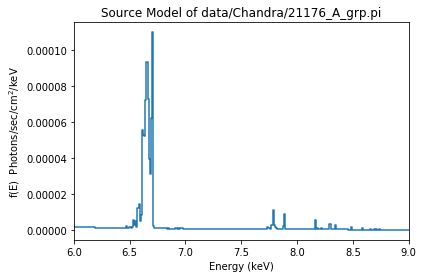

In [191]:
ui.plot_source('21176_A')
ax = plt.gca()
ax.set_xlim(6, 9.)

In [120]:
print(ui.get_source('21176_A'))

(xsphabs.Aa_2018 * (xsvapec.Av1_2018 + xsvapec.Av2_2018))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Aa_2018.nH   thawed      8.38592            0       100000 10^22 atoms / cm^2
   Av1_2018.kT  frozen            1       0.0808       68.447        keV
   Av1_2018.He  frozen            1            0         1000           
   Av1_2018.C   frozen            1            0         1000           
   Av1_2018.N   frozen            1            0         1000           
   Av1_2018.O   frozen            1            0         1000           
   Av1_2018.Ne  frozen            1            0         1000           
   Av1_2018.Mg  frozen            1            0         1000           
   Av1_2018.Al  frozen            1            0         1000           
   Av1_2018.Si  thawed      6.66696            0         1000           
   Av1_2018.S   frozen            1            0         1

In [105]:
a_models['2019'].rhs.lhs.Si.frozen = False
a_models['2019'].rhs.lhs.Ca.frozen = False
a_models['2019'].rhs.lhs.Fe.frozen = False

abs1 = a_models['2019'].lhs
xsv1 = a_models['2019'].rhs.lhs
xsv2 = a_models['2019'].rhs.rhs

for o in ['22323_A', '23100_A', '23101_A', '23102_A', '2019_A']:
    ui.set_source(o, abs1 * (xsv1 + xsv2))

In [106]:
ui.notice(.4, 8.)
ui.ignore(8., None)
ui.ignore(None, .5)

In [107]:
#ui.set_source('21176_A', abs1 * (xsv1 + xsv2))

xsv1.kT = 1.
xsv2.kT = 1.8
xsv1.kT.frozen = True
xsv2.kT.frozen = False
xsv1.norm = 1e-5
xsv2.norm = 1e-5
xsv2.norm.frozen=False

Datasets              = '22323_A', '23100_A', '23101_A', '23102_A'
Method                = levmar
Statistic             = cash
Initial fit statistic = 2364.74
Final fit statistic   = 1973.38 at function evaluation 456
Data points           = 4096
Degrees of freedom    = 4089
Change in statistic   = 391.357
   Aa_2019.nH     3.81785      +/- 0.78093     
   Av1_2019.Si    0.00115837   +/- 4.21506     
   Av1_2019.Ca    13.5818      +/- 15.4915     
   Av1_2019.Fe    8.51145      +/- 3.13279     
   Av1_2019.norm   2.60946e-06  +/- 2.00199e-05 
   Av2_2019.kT    4.32255      +/- 1.69302     
   Av2_2019.norm   4.22626e-05  +/- 1.33981e-05 


/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)


/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)


/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)


/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)
/Users/guenther/anaconda3/envs/ciao-4.12/lib/python3.7/site-packages/sherpa/plot/pylab_backend.py:330: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  zorder=zorder)


(6.0, 7.0)

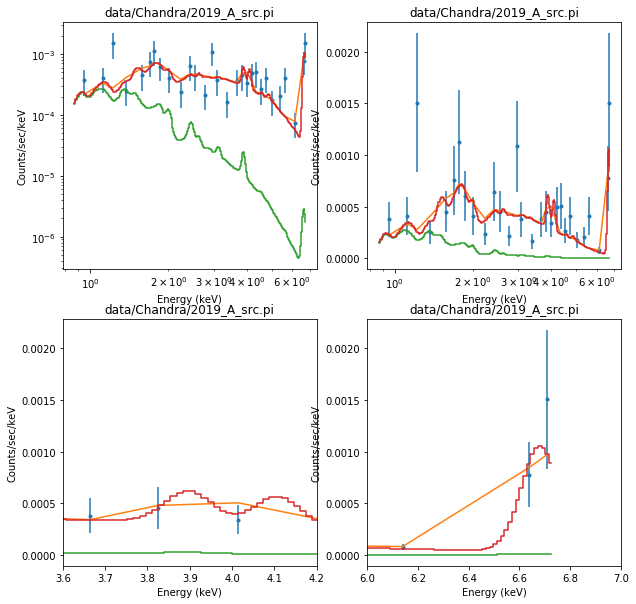

In [108]:
fig, axes= plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
#ui.set_stat('chi2gehrels')
#for o in ['22323_A', '23100_A', '23101_A', '23102_A']:
#    ui.ungroup(o)
#ui.unsubtract('21176_A')
ui.set_stat('cash')
#ui.ignore(None, 1.5)
ui.fit('22323_A', '23100_A', '23101_A', '23102_A')
# For speed in experimenting I might want to fit 2019_A instead. 
ui.group_counts('2019_A', 5)
for ax in axes.flatten():
    plt.sca(ax)
    ui.plot_fit('2019_A', clearwindow=False)
    ui.plot_model_component('2019_A', abs1 * xsv1, overplot=True)
    ui.plot_model_component('2019_A', abs1 * xsv2, overplot=True)
    
axes[0, 0].loglog()
axes[0, 1].semilogx()
axes[1, 0].set_xlim(3.6, 4.2)
axes[1, 1].set_xlim(6., 7.)

In [202]:
1250 + 700 + 700 + 375 + 100

3125

In [109]:
print(ui.get_source('22323_A'))

(xsphabs.Aa_2019 * (xsvapec.Av1_2019 + xsvapec.Av2_2019))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Aa_2019.nH   thawed      3.81785            0       100000 10^22 atoms / cm^2
   Av1_2019.kT  frozen            1       0.0808       68.447        keV
   Av1_2019.He  frozen            1            0         1000           
   Av1_2019.C   frozen            1            0         1000           
   Av1_2019.N   frozen            1            0         1000           
   Av1_2019.O   frozen            1            0         1000           
   Av1_2019.Ne  frozen            1            0         1000           
   Av1_2019.Mg  frozen            1            0         1000           
   Av1_2019.Al  frozen            1            0         1000           
   Av1_2019.Si  thawed   0.00115837            0         1000           
   Av1_2019.S   frozen            1            0         1

In [154]:

ui.fit('21176_A')
ui.fit('22323_A', '23100_A', '23101_A', '23102_A')

Dataset               = 14539_A
Method                = levmar
Statistic             = cash
Initial fit statistic = 1.46682e+07
Final fit statistic   = -115.686 at function evaluation 545
Data points           = 868
Degrees of freedom    = 862
Change in statistic   = 1.46683e+07
   Aa_2013.nH     0.0864066    +/- 0.0551437   
   Av1_2013.kT    11.5907      +/- 0           
   Av1_2013.Ne    0.000909321  +/- 6.61622     
   Av1_2013.Fe    4.31295e-05  +/- 0.606703    
   Av1_2013.norm   7.55184e-09  +/- 1.87998e-05 
   Av2_2013.norm   0.000171816  +/- 1.90084e-05 
Datasets              = '17764_A', '19980_A'
Method                = levmar
Statistic             = cash
Initial fit statistic = 1.2927e+06
Final fit statistic   = 932.293 at function evaluation 128
Data points           = 1380
Degrees of freedom    = 1375
Change in statistic   = 1.29176e+06
   Aa_2017.nH     37.649       +/- 5.95759     
   Av1_2017.kT    1.36552      +/- 0.219411    
   Av1_2017.Fe    18.7466      +/- 13.142

In [181]:
print(a_models['2018'])

(xsphabs.Aa_2018 * (xsvapec.Av1_2018 + xsvapec.Av2_2018))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Aa_2018.nH   thawed      4.01717            0       100000 10^22 atoms / cm^2
   Av1_2018.kT  thawed      5.43713       0.0808       68.447        keV
   Av1_2018.He  frozen            1            0         1000           
   Av1_2018.C   frozen            1            0         1000           
   Av1_2018.N   frozen            1            0         1000           
   Av1_2018.O   frozen            1            0         1000           
   Av1_2018.Ne  frozen            1            0         1000           
   Av1_2018.Mg  frozen            1            0         1000           
   Av1_2018.Al  frozen            1            0         1000           
   Av1_2018.Si  frozen            1            0         1000           
   Av1_2018.S   frozen            1            0         1

Text(0.5, 1, 'RW Aur A')

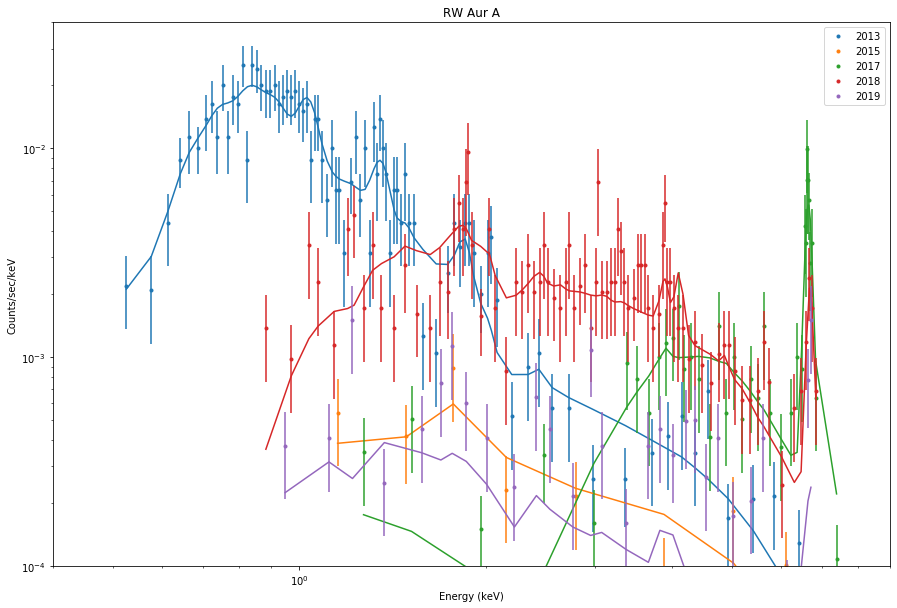

In [166]:
# Use the following line to change the size of the figure
fig = plt.figure(figsize=(15,10))

for i in ui.list_data_ids():
    if i[-2:] == '_A':
        ui.group_counts(i, 5)

for i,j  in enumerate(plotorder):
    ui.plot_fit(data['filestem'][j] + '_A', overplot=not(i==0), color=data['color'][j])
    
ax = plt.gca()
ax.loglog()
ax.set_xlim(.4, 9)
ax.set_ylim(1e-4, 0.04)
ax.legend(ax.get_lines()[::2], data['year'][plotorder])
ax.set_title('RW Aur A')
#fig.savefig('figout/spectraA_2019.pdf', bbox_inches='tight')

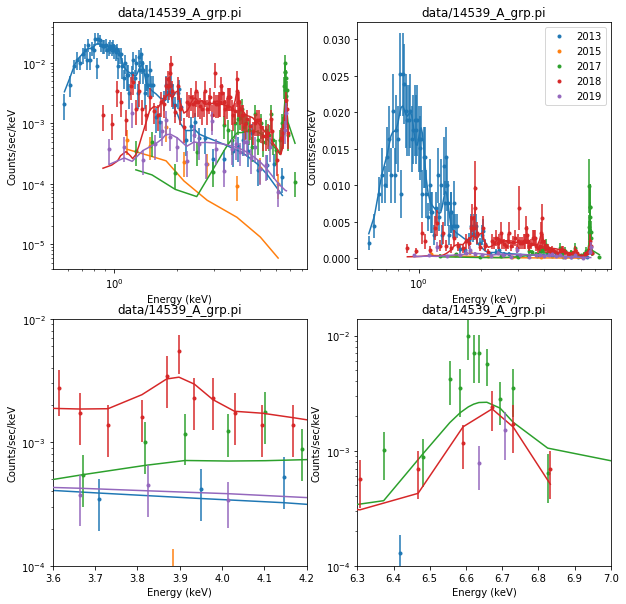

In [314]:
fig, axes= plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

for i in ui.list_data_ids():
    if i[-2:] == '_A':
        ui.group_counts(i, 5)

for ax in axes.flatten():
    plt.sca(ax)
    for i,j  in enumerate(plotorder):
        ui.plot_fit(data['filestem'][j] + '_A', overplot=not(i==0), color=data['color'][j], clearwindow=False)
    
axes[0, 0].loglog()
axes[0, 1].semilogx()
axes[1, 0].set_xlim(3.6, 4.2)
axes[1, 1].set_xlim(6.3, 7.0)
axes[1, 0].set_ylim(1e-4, .01)
axes[1, 1].set_ylim(1e-4, .014)
axes[1, 0].semilogy()
axes[1, 1].semilogy()
axes[0, 1].legend(ax.get_lines()[::2], data['year'][plotorder])

In [ ]:
ui.set_analysis('energy')
ui.notice(.3, 9)
for i in ui.list_data_ids():
    ui.group_counts(i, 5)
    
for i in plotorder:
    ui.plot_data(21 + i, overplot=True)
    
ax = plt.gca()
#ax.loglog()
ax.semilogy()
ax.set_xlim(.2, 8)
ax.set_ylim(1e-4, 0.04)
ax.legend(ax.get_lines()[1::2], data['year'][plotorder], loc=(.55, .65))
ax.set_xlabel('energy [keV]')
ax.set_ylabel('Flux [cts/s/keV]')
fig = plt.gcf()
fig.savefig(figdir + 'spectraA.pdf', bbox_inches='tight')

In [ ]:
ui.set_analysis('energy')
ui.notice(.3, 9)
for i in ui.list_data_ids():
    ui.group_counts(i, 5)
    
for i in plotorder:
    ui.plot_data(21 + i, overplot=True)
    
ax = plt.gca()
#ax.loglog()
ax.semilogy()
ax.set_xlim(.2, 7.5)
ax.set_ylim(3e-4, 0.04)
ax.legend(ax.get_lines()[1::2], data['year'][plotorder], loc='lower right')
ax.set_xlabel('energy [keV]')
ax.set_ylabel('Flux [cts/s/keV]')
fig = plt.gcf()
#ax.set_title("")
fig.set_size_inches(12, 4)

c = [l.get_c() for l in ax.get_lines()[1::2]]

def annotate(text, pos, offset, color):
    ax.annotate(text, color=color, fontsize='large',
            xy=pos, xycoords='data',
            xytext=offset, textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.9"),
            arrowprops=dict(arrowstyle="->", color=color, linewidth=2,
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"))

annotate('Fe 6.7 keV', (6.7, 4e-3), (10, 30), c[3])
annotate('Fe 6.62 keV', (6.62, 1.4e-2), (-10, 30), c[2])
annotate('Ca XIX triplet', (3.88, 8e-3), (-10, 30), c[3])
annotate('Ca XX', (4.1, 3e-3), (10, 30), c[3])
annotate('Si XIII triplet', (1.85, 1.5e-2), (-10, 30), c[3])
annotate('Si XIV', (2.0, 5e-3), (10, 30), c[3])

import matplotlib.patches as mpatches
arrow = mpatches.Arrow(.6, 3e-3, 1, -2e-3, width=3e-3, color='0.6')
ax.add_patch(arrow)


fig.savefig(figdir + 'spectraA.pdf', bbox_inches='tight')

In [ ]:
l = ax.get_lines()[1::2][0]
l.get_c()

In [ ]:
ui.set_analysis('energy')
ui.notice(.3, 9)

for i,j  in enumerate(plotorder):
    ui.group_counts(data['filestem'][j] + '_A', 3)
    ui.plot_fit(data['filestem'][j] + '_A', overplot=True, color=mplcolors[i])
   
ax = plt.gca()
ax.set_xlim(6.3, 7.2)
ax.set_ylim(1e-4, 0.015)
ax.semilogy()
ax.legend(ax.get_lines()[1::2], data['year'][plotorder])
ax.set_xlabel('energy [keV]')
ax.set_ylabel('Flux [cts/s/keV]')
fig = plt.gcf()
fig.savefig(figdir + 'spectraAFe.pdf', bbox_inches='tight')

In [ ]:
for i in ui.list_data_ids():
    ui.group_counts(i, 5)
    
for i in plotorder:
    ui.plot_data(21 + i, overplot=True)
    
ax = plt.gca()
ax.set_xlim(1, 2)
ax.set_ylim(0, 0.015)
ax.legend(ax.get_lines()[1::2], data['year'][plotorder])

In [ ]:
import astropy.units as u
(3.8 * u.keV).to(u.Angstrom, equivalencies=u.spectral())

In [ ]:

# FIP values from NIST
# https://physics.nist.gov/cgi-bin/ASD/ie.pl?spectra=H-DS+i&units=1&at_num_out=on&el_name_out=on&shells_out=on&level_out=on&e_out=0&unc_out=on&biblio=on
'''
@Misc{NIST_ASD,
author = {A.~Kramida and {Yu.~Ralchenko} and
J.~Reader and {and NIST ASD Team}},
HOWPUBLISHED = {{NIST Atomic Spectra Database
(ver. 5.6.1), [Online]. Available:
{\tt{https://physics.nist.gov/asd}} [2018, November 30].
National Institute of Standards and Technology,
Gaithersburg, MD.}},
year = {2018},
}
'''


In [ ]:
Av42.kT=0.8
Av42.norm=1e-5



In [ ]:
ui.set_source(25, "xsphabs.Aa4 * (xsvapec.Av41 + xsvapec.Av42 + xsvapec.Av43)")

for elem in ['Fe', 'Mg', 'Al', 'Si', 'S', 'Ca', 'Ni']:
    getattr(Av41, elem).frozen = False
    getattr(Av42, elem).link = getattr(Av41, elem)
    getattr(Av43, elem).link = getattr(Av41, elem)

for elem in ['Mg', 'Al', 'Si', 'S', 'Ca', 'Ni']:
    getattr(Av41, elem).link = Av41.Fe

Av41.Fe.frozen=False
Av41.Ne.frozen=False
Av41.Ca.frozen=False
ui.unlink(Av41.Ca)
Av41.Fe = 1
Av41.Ne = 1
Av42.kT = 1.
Av42.norm = 0.001

Av43.norm = 0
Av43.norm.frozen = True
Av43.kT.frozen = True
#ui.ungroup(25)
ui.set_stat('cstat')
ui.notice(.3, 9.)
ui.ignore(None, 0.3)
ui.ignore(9., None)
ui.fit(25)

In [ ]:
ui.set_analysis("energy")
ui.group_counts(25, 3)
ui.plot_fit(25)
ax = plt.gca()
#ax.loglog()
#ax.set_xlim(1.5, 7)
ax.set_ylim(1e-4, 0.01)
fig = plt.gcf()
ax.set_title("")
fig.set_size_inches(12, 4)
fig.savefig(figdir + 'spectraA18.pdf', bbox_inches='tight')

In [ ]:
ui.group_counts(25, 3)
ui.plot_data(26)
ui.plot_fit(25, overplot=True)
ax = plt.gca()
ax.set_xlim(6.3, 7)
#ax.set_ylim(1e-4, 0.005)

In [ ]:
ui.show_model(25, outfile=sys.stdout)

In [ ]:
ui.set_source(25, "xsphabs.Aa4a * (xsvapec.Av41a + xsvapec.Av42a)")

for elem in ['Fe', 'Mg', 'Al', 'Si', 'S', 'Ca', 'Ni']:
    #getattr(Av41a, elem).frozen = False
    getattr(Av42a, elem).link = getattr(Av41, elem)

#for elem in ['Mg', 'Al', 'Si', 'S', 'Ca', 'Ni']:
#    getattr(Av41, elem).link = Av41.Fe

Av41a.Fe.frozen=False
Av41a.Si.frozen=False
Av41a.Ca.frozen=False
Av42a.Fe.frozen=False
Av42a.Si.frozen=False
Av42a.Ca.frozen=False

ui.unlink(Av42a.Si)
ui.unlink(Av42a.Ca)
ui.unlink(Av42a.Fe)
Av41a.Fe = 1
Av41a.Ne = 1
Av41a.kT=.5
Av42a.kT = 2.
Av42a.norm = 0.001

#ui.ungroup(25)
ui.set_stat('cstat')
ui.notice(.3, 9.)
ui.ignore(None, 0.3)
ui.ignore(9., None)
ui.fit(25)

In [ ]:
ui.set_analysis("energy")
ui.group_counts(25, 5)
ui.plot_fit(25)
ax = plt.gca()
#ax.loglog()
#ax.set_xlim(1.5, 7)
ax.set_ylim(1e-4, 0.01)
fig = plt.gcf()
ax.set_title("")
fig.set_size_inches(12, 4)

# 2018 flare vs non-flare

In [ ]:
ui.load_data(100, datadir + '21176_A_grp.pi')
ui.load_data(101, datadir + '21176_A_noflare_grp.pi')
ui.load_data(102, datadir + '21176_A_flare_grp.pi')

In [ ]:

for i in range(0, 3):
    ui.ungroup(100 + i)
    ui.ignore_bad(100 + i)

ui.set_analysis("energy")
ui.ignore(None, 0.3)
ui.ignore(9., None)

In [ ]:

for i in range(0, 3):
    ui.set_analysis("energy")
    ui.group_counts(100+i, 5)
    ui.ignore(None, 0.3)
    ui.ignore(9., None)

    ui.plot_data(100+i, overplot=True)
    
ui.plot_model(25, overplot=True)

ax = plt.gca()
#ax.loglog()
#ax.set_xlim(.6, 8)
#ax.set_ylim(1e-4, 0.02)
ax.set_xlim(1, 7)
ax.set_ylim(1e-4, 0.02)
fig = plt.gcf()
fig.set_size_inches(14, 5)